# Introduction

The idea for this notebook is to approach the problem from something easy to understand, in this case regression on purely continuous variables, before scaling up in complexity.  We'll perform the usual multiple regression before regularizing accordingly. 

First lets read in the data and briefly look at the label we're trying to predict:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats


df =  pd.read_csv('data/train.csv').set_index('Id')
df_test = pd.concat([pd.read_csv('data/test.csv').set_index('Id'),
                    pd.read_csv('data/sample_submission.csv').set_index('Id')],1)
df = pd.concat([df, df_test])
print(df.SalePrice.describe())

count      2919.000000
mean     180052.854647
std       57381.565721
min       34900.000000
25%      154795.084126
50%      176734.841494
75%      191895.744157
max      755000.000000
Name: SalePrice, dtype: float64


# Initial Outlier Detection

From intro stats lets check the data with the 68-95-99.7 rule with respect to one-, two-, and three-standard deviations

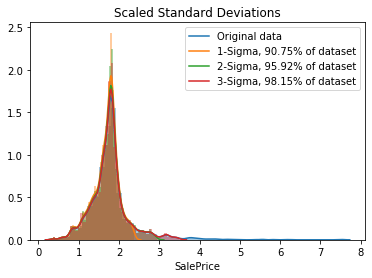

In [2]:
def trim(df,std_dev=1, scale = False, return_df = False):
    '''
    From intro stats, check the 68-95-99.7 rule with respect to 1-sd, 2-sd,
    3-sd.
    '''
    mu = df.SalePrice.mean()
    sigma = df.SalePrice.std()
    if scale:
        scale = 100000
    else:
        scale = 1
    trimmed_df = df.loc[(abs(df.SalePrice) <= (mu + std_dev*sigma))]
    data = trimmed_df.SalePrice
    if return_df:
        return trimmed_df
    else:
        label = str(std_dev) + "-Sigma, " + str(round(100*data.shape[0]/df.SalePrice.shape[0],2)) + "% of dataset"
        sbn.distplot(data/scale, kde_kws = {"label": label})
    
sbn.distplot(df.SalePrice/100000, kde_kws={"label": "Original data"})
trim(df,1,True)
trim(df,2,True)
trim(df,3,True)
plt.title('Scaled Standard Deviations')
plt.show()

Note the large peak in the distribution, prompting us to check skewness and kurtosis for features "SalePrice" and the log of SalePrice, the latter in reference to the work done by another Kaggle notebook (https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python by Pedro Marcelino)

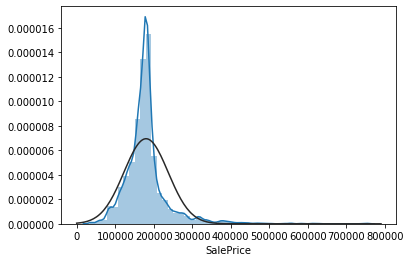

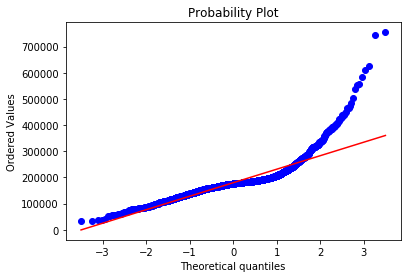

The kurtosis: 14.63787275141075
The skew: 2.5479382085715123


In [3]:
def check_skew_kurtosis(df, feature = 'SalePrice', pics_only = False,):
    '''
    Overlay a normal pdf onto the plot of the feature of interest to visually
    observe its deviation from normality
    '''
    y = df[feature]
    sbn.distplot(y, fit=norm)
    plt.figure()
    stats.probplot(y, plot=plt)
    plt.show()
    print('The kurtosis: ' + str(stats.kurtosis(y)))
    print('The skew: ' + str(stats.skew(y)))
    
check_skew_kurtosis(df)

Observing the skewness and kurtosis, lets take the log of the SalePrice and try to observe how much closer we can get the distribution to normality:

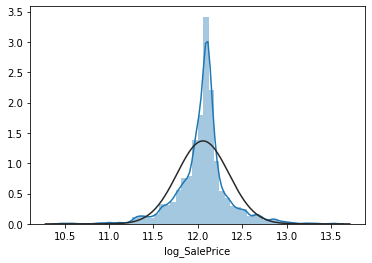

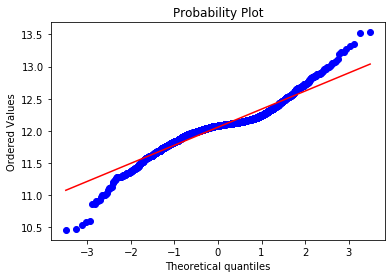

The kurtosis: 3.731625568003553
The skew: -0.15030378710305026


In [4]:
df['log_SalePrice'] = np.log(df['SalePrice'])
check_skew_kurtosis(df,'log_SalePrice')

We see that both the distribution and theoretical quantiles align more closely with that of a normally distributed feature, with correspondingly smaller kurtosis and skewness. From the article (https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics) and other justification we deduce skewness and kurtosis not to be particularly useful, hence we may try regression with both logged and unlogged SalePrice and compare accordingly.

From the graphics we trim the dataset to records with feature SalePrice falling within two standard-deviations of the mean SalePrice.  We may come back and attempt regression without trimming the dataset.

In [5]:
df = trim(df,2,return_df = True)

# Feature Selection

First lets look at all features satisfying numerical type

In [6]:
print(df.select_dtypes(exclude = ['object']).head())

    MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                          
1           60         65.0     8450            7            5       2003   
2           20         80.0     9600            6            8       1976   
3           60         68.0    11250            7            5       2001   
4           70         60.0     9550            7            5       1915   
5           60         84.0    14260            8            5       2000   

    YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  OpenPorchSF  \
Id                                                    ...                
1           2003       196.0       706.0         0.0  ...           61   
2           1976         0.0       978.0         0.0  ...            0   
3           2002       162.0       486.0         0.0  ...           42   
4           1970         0.0       216.0         0.0  ...           35   
5           2000

We notice that some features having strictly numerical values aren't continuous, for example ordinal categoricals.  Lets exclude them right away and perform some quick data cleaning:

In [7]:
drop_cols = list(df.select_dtypes(exclude = ['number']).columns)
[drop_cols.append(col) for col in ['MSSubClass','OverallQual','OverallCond', 'MiscVal']]

'quick cleaning:'
df['LotFrontage'].replace(np.nan,0, inplace = True)
df['MasVnrArea'].replace(np.nan,0, inplace = True)

Next let's try to find features that correlate with each other and subsequently remove them from our dataset.  For this we only really care about the magnitude of correlation versus positive or negative

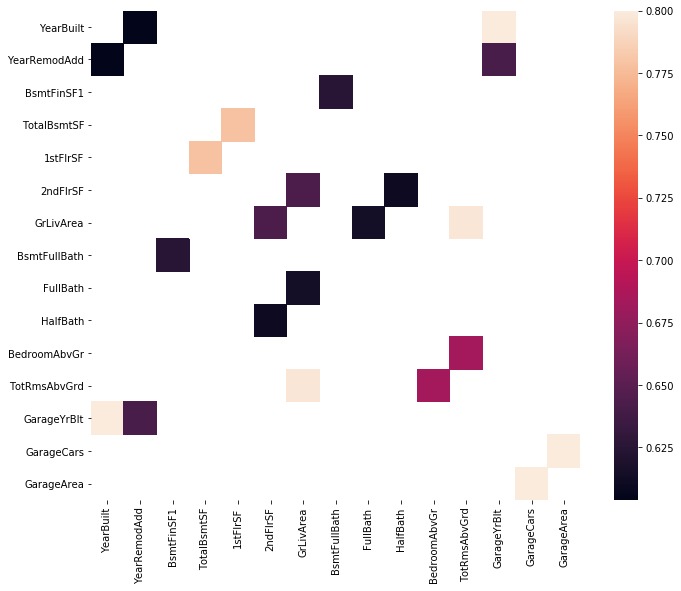

In [8]:
def abs_corr(df, drop_cols = [], min_val = .6, max_val = 1, plot_me = True, plot_x = 12, plot_y = 9):
    if len(drop_cols) > 0:
        drop_cols = list(set(drop_cols))
        df = df[[i for i in df.columns if i not in drop_cols]]
    abs_mtx = df.drop(columns = 'SalePrice').corr().abs()
    
    mtx = abs_mtx[(abs_mtx < max_val) & (abs_mtx >= min_val)].dropna(1, 'all').dropna(0, 'all')
    if plot_me:
        plt.subplots(figsize=(plot_x, plot_y))
        sbn.heatmap(mtx, vmax=.8, square=True)
        plt.show()
    else:
        return mtx

abs_corr(df.drop(columns = 'log_SalePrice'), drop_cols)

From the figure we can see that features 1stFlrSF and TotalBsmtSF are highly correlated. It isn't uncommon for the 1st floor's square footage to equal that of the basement, and not all houses have a basement but definitly have a first floor.

Also, GarageCars highly correlates with GarageArea, and is less informative. Next, the YearBuilt correlates strongly with GarageYrBlt (agreeing with intuition), and is more informative.
TotRmsAbvGrd highly correlates with GrLivArea, is less informative, and seems to be captured by living area as well as bedrooms above ground.  Therefore we add the following features to be dropped:

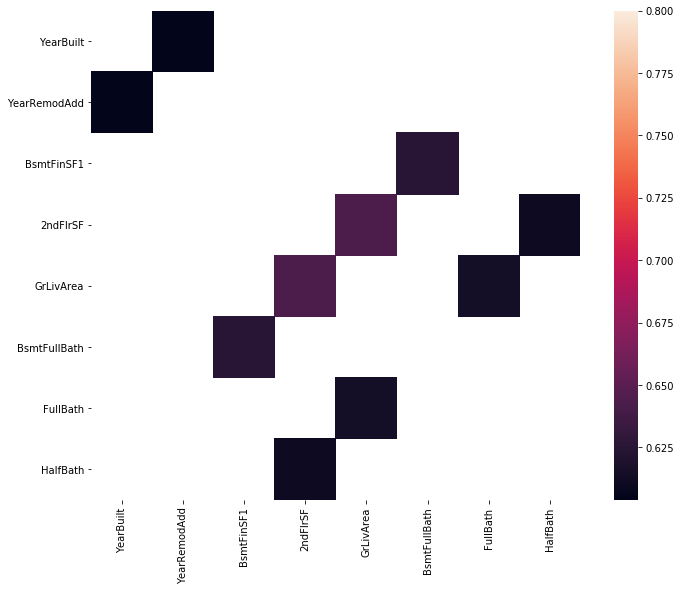

In [9]:
[drop_cols.append(i) for i in ['GarageYrBlt', 'GarageCars','TotalBsmtSF', 'TotRmsAbvGrd']]
abs_corr(df.drop(columns = 'log_SalePrice'), drop_cols)

The remaining correlations arent as strong, but we note 2ndFlrSF and GrLivArea. We'll leave them for now since I find them both to be informative for different reasons, but may drop one of them depending on model performance

In [10]:
df.drop(columns = drop_cols, inplace = True)

# Feature Engineering and Final Data Prep

Right away lets alter the time field to a format we can use for the regression:

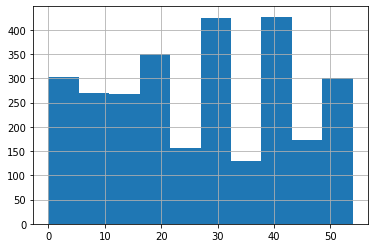

In [11]:
from operator import attrgetter
df.rename(columns = {'YrSold': 'year','MoSold':'month'}, inplace = True)
df['day'] = 1
df['date_sold'] = pd.to_datetime(df[['year', 'month','day']])
df['min_sell_date'] = df.date_sold.min()
min_sell_date = df['min_sell_date'].iloc[0]
df['months_since_sold'] = (df.date_sold.dt.to_period('M') - df.min_sell_date.dt.to_period('M')).apply(attrgetter('n'))
[df.drop(columns = date_col, inplace = True) for date_col in ['year', 'month','day', 'date_sold', 'min_sell_date']]


df['months_since_sold'].hist() # a quick histogram
plt.show()

Next lets look at missing values:

In [12]:
miss = df.isnull().sum()
miss.loc[miss >0]

BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
BsmtFullBath    2
BsmtHalfBath    2
GarageArea      1
dtype: int64

In [13]:
for feature in ['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','GarageArea']:
    print('Row of missing values for feature ' + feature+ ':')
    print(df.loc[df[feature].isna()])
    print('\n')

Row of missing values for feature BsmtFullBath:
      LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id                                                                            
2121         99.0     5940       1946          1950         0.0         NaN   
2189        123.0    47007       1959          1996         0.0         0.0   

      BsmtFinSF2  BsmtUnfSF  1stFlrSF  2ndFlrSF  ...  GarageArea  WoodDeckSF  \
Id                                               ...                           
2121         NaN        NaN       896         0  ...       280.0           0   
2189         0.0        0.0      3820         0  ...       624.0           0   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
Id                                                                   
2121            0              0          0            0         0   
2189          372              0          0            0         0   

          SalePrice  log_SalePric

Looking at the data, the record at indices 2121 and 2189 are missing values for all basement-related features,
so I presume this means there doesnt exist a basement. Also, missing GarageArea seems to indicate lackthereof. Impute accordingly and make final adjustmentes for modelling:

In [14]:
df.loc[df.index.isin([2121, 2189]),['BsmtFullBath', 'BsmtHalfBath']] = 0
df.loc[df.index == 2121, ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']] = 0
df.loc[df['GarageArea'].isna(),['GarageArea']] = 0

#final check of missing vals
miss = df.isnull().sum()
miss.loc[miss >0]

Series([], dtype: int64)

In [15]:
df = df.sample(frac = 1) #shuffle in case the data came in an ordered manner
X = df.drop(columns = ['SalePrice','log_SalePrice'])

#drop time columns that dont need normalization, attach them after normalizing
X.drop(inplace = True, columns = ['YearBuilt','YearRemodAdd','months_since_sold'])
X = (X - X.mean())/X.std()
X = X.merge(df[['YearBuilt','YearRemodAdd','months_since_sold']], left_index = True, right_index = True)
y = df['SalePrice']

# Modelling

In [16]:
import sklearn
from sklearn import linear_model as lm
from sklearn.model_selection import cross_validate as cv

Now we'll build our usual multiple-regression model before regularizing it with ridge and lasso.  We'll also score the performance of each model and plot its respective predictions:

In [17]:
def get_score_and_model(list_of_scores, list_of_models, get_max = True):
    '''
    Given a list of test scores and the corresponding list of models, 
    obtain the min/max score and its corresponding model
    '''
    if get_max:
        score_val = max(list_of_scores)
    else:
        score_val = min(list_of_scores)
        
    index_of_score = np.where(list_of_scores == score_val)[0][0] #[0][0] to get the value from the tuple
    corresponding_model = list_of_models[index_of_score]
    return score_val, corresponding_model

def build_and_eval(X,y, extra = None, scorer = 'r2',get_max = True,
                   return_models = False, return_optimal = False,
                   score_options = False, omni_seed = 8):
    '''
    Taking a (normalized) X and its corresponding y, the function builds a 
    multiple-regression model before attempting to regularize with ridge and
    lasso. The function returns a dictionary of the models, specified by regu-
    larizer (i.e. 'lasso', 'ridge', or 'normal'[no regularization performed]), 
    with the option to return only the best-performing model of each regulari-
    zation type
    '''
    if score_options: score_options()
    model_holder = {'Normal':[] ,'Ridge':[], 'Lasso':[]}
    baseline = cv(lm.LinearRegression(fit_intercept = True), X, y, cv = 20,
                      scoring = scorer, return_estimator = True)
    model_holder['Normal'] = baseline['estimator']
    if get_max:
        precurser = 'Largest ' + scorer + ': '
    else:
        precurser = 'Smallest ' + scorer + ': '
        
    if extra is None:
        print('Multiple Regression:')
    else:
        print('Multiple Regression ' + extra + ':')
    print(precurser +  str(baseline['test_score'].max()) + '\n')
    
    # regularize
    reg_vals = {'penalty':list(range(1,21)), 'Ridge':list(), 'Lasso':list() }
    
    for penalty in reg_vals['penalty']:
        ridger = cv(lm.Ridge(alpha = penalty, random_state = omni_seed), X, y, scoring = scorer,
                    cv = 10, return_estimator = True)
        lasso = cv(lm.Lasso(alpha = penalty, max_iter = 50000, random_state = omni_seed), X, y, scoring = scorer,
                   cv = 10, return_estimator = True)
        
        #obtain the min/max score and the corresponding model
        s,c = get_score_and_model(ridger['test_score'],ridger['estimator'], get_max = get_max)
        reg_vals['Ridge'].append(round(s,3))
        model_holder['Ridge'].append(c)
        
        s,c = get_score_and_model(lasso['test_score'], lasso['estimator'], get_max = get_max)
        reg_vals['Lasso'].append(round(s,3))
        model_holder['Lasso'].append(c)
        
    best_alpha = {'Ridge':0, 'Lasso':0} # use to obtain the best models based on scoring
    for val in ['Ridge', 'Lasso']:
        v = min(reg_vals[val])
        print(val + ' Regression:')
        best_alpha[val] = reg_vals['penalty'][reg_vals[val].index(v)] 
        print(precurser + str(v) + ' for corresponding alpha = ' +
              str(best_alpha[val]) + '\n')
    
    if return_optimal:
        return_models = True
        for val in ['Ridge', 'Lasso']:
            model_holder[val] = [m for m in model_holder[val] if m.alpha == best_alpha[val]]
    
    if return_models:
        return model_holder

In [18]:
#model_dict = build_and_eval(X,y, scorer = 'neg_mean_squared_error', return_optimal = True)
model_dict = build_and_eval(X,y, scorer = 'r2', return_optimal = True)

Multiple Regression:
Largest r2: 0.4977774064720135

Ridge Regression:
Largest r2: 0.476 for corresponding alpha = 1

Lasso Regression:
Largest r2: 0.476 for corresponding alpha = 1



Let's try prediction with these models and evaluate the residuals:

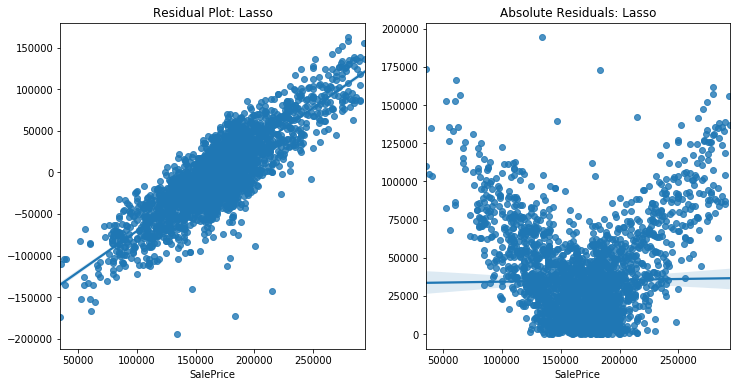

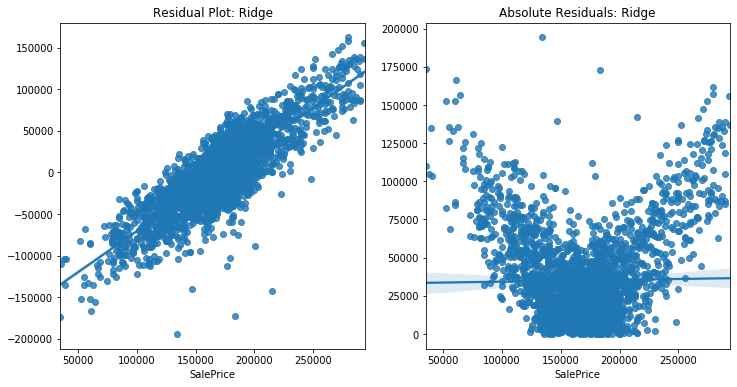

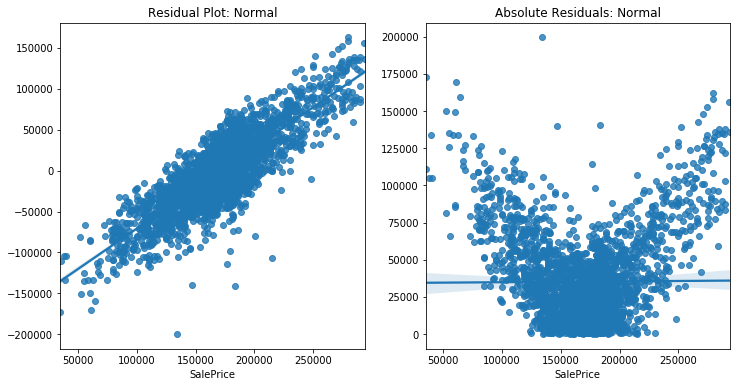

In [19]:
def absolute_diff(model,X,df, preamble = None):
    ''' 
    Predicts SalePrice feature and plots residuals and absolute residuals 
    against true SalePrice values
    '''
    if type(model) is list:
        model = model[0]
    y_eval = pd.Series(model.predict(X)).reindex(X.index)
    y_eval.name = 'pred_SalePrice'
    x2 = df.merge(y_eval, left_index = True, right_index = True)
    x2['resid'] = x2.SalePrice - x2.pred_SalePrice
    x2['abs_resid'] = abs(x2.resid)
    
    addendum = ''
    if preamble is not None:
        addendum = ': ' + preamble
    
    plt.subplots(figsize = (12,6))
    plt.subplot(1,2,1)
    sbn.regplot('SalePrice','resid', data = x2).set_title('Residual Plot' + addendum)
    plt.ylabel('')
    
    plt.subplot(1,2,2)
    sbn.regplot('SalePrice','abs_resid', data = x2).set_title('Absolute Residuals'+ addendum)
    plt.ylabel('')
    plt.show()
    
absolute_diff(model_dict['Lasso'],X,df,'Lasso')
absolute_diff(model_dict['Ridge'],X,df,'Ridge')
absolute_diff(model_dict['Normal'][0],X,df,'Normal')

From the above graphics we see a correlation between the residuals and the SalePrice, which is highly problematic.  Lets bring back the original data and try including the ordinals

In [20]:
d1 =  pd.read_csv('data/train.csv').set_index('Id')
d2 = pd.concat([pd.read_csv('data/test.csv').set_index('Id'),
                    pd.read_csv('data/sample_submission.csv').set_index('Id')],1)
df_original = pd.concat([d1, d2])

ordinals = [i for i in df_original.select_dtypes(exclude = ['object']).columns if i not in list(df.columns)]
print(df_original[ordinals].head(3))

    MSSubClass  OverallQual  OverallCond  TotalBsmtSF  TotRmsAbvGrd  \
Id                                                                    
1           60            7            5        856.0             8   
2           20            6            8       1262.0             6   
3           60            7            5        920.0             6   
4           70            7            5        756.0             7   
5           60            8            5       1145.0             9   

    GarageYrBlt  GarageCars  MiscVal  MoSold  YrSold  
Id                                                    
1        2003.0         2.0        0       2    2008  
2        1976.0         2.0        0       5    2007  
3        2001.0         2.0        0       9    2008  
4        1998.0         3.0        0       2    2006  
5        2000.0         3.0        0      12    2008  


We'll discard the columns that aren't truly ordinals and quickly see how the remaining features change with respect to SalePrice:

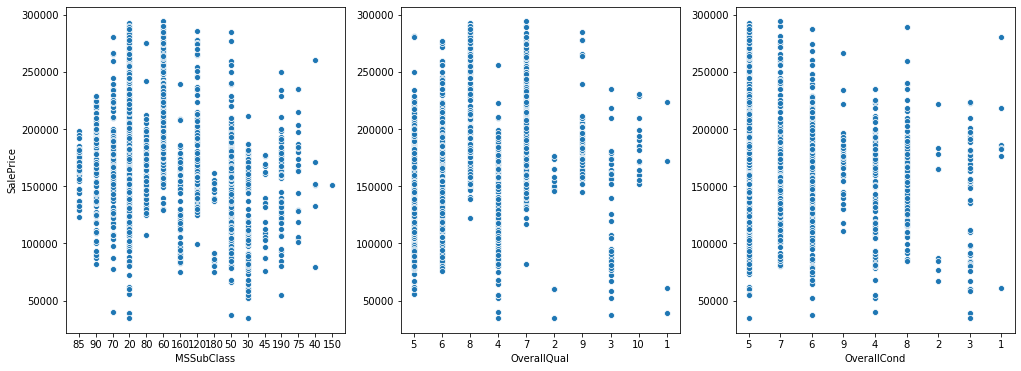

In [21]:
categoricals = [i for i in ordinals if i not in ['GarageYrBlt','GarageCars','MiscVal', 'MoSold', 'YrSold', 'TotRmsAbvGrd','TotalBsmtSF']]
df = df.merge(df_original[categoricals], right_index = True, left_index = True)

plt.subplots(figsize = (17,6))
i = 1
for feature in categoricals:
    df[feature] = df[feature].astype('str')
    plt.subplot(1,3,i)
    
    sbn.scatterplot(x = feature, y = 'SalePrice', data = df)
    if i >1: plt.ylabel('')
    if i ==3:
        plt.show()
    i +=1


We can faintly see the minimum SalePrice increasing as we improve in quality, but no other immediate discernable pattern. It also isnt obvious how MSSubClass affects SalePrice. Lets check for pair-wise correlation between each of these features with the Pearson chi-square test (potentially helpful link to explain the test: https://datascience.stackexchange.com/questions/893/how-to-get-correlation-between-two-categorical-variable-and-a-categorical-variab)


In [22]:
from scipy.stats import chi2_contingency
from copy import copy
print('Chi-squared Tests with null hypotheses that, pair-wise, the compared features are independent\n')
for feature in categoricals:
    features = copy(categoricals)
    features.remove(feature)
    p = chi2_contingency(pd.crosstab(df[features[0]], df[features[1]]))[1]
    print('Features: ' + features[0] + ', ' + features[1] +
          '\np-value: ' + str(p) + '\n')

Chi-squared Tests with null hypotheses that, pair-wise, the compared features are independent

Features: OverallQual, OverallCond
p-value: 1.309155044028234e-188

Features: MSSubClass, OverallCond
p-value: 3.903657713949611e-121

Features: MSSubClass, OverallQual
p-value: 2.1651456645887066e-176



From the above we see strong pair-wise correlation between each pair of categoricals. Lets include each of them, one at a time, into the broader dataset and evaluate our model:

In [23]:
y = df['SalePrice']
X = df.drop(columns = (categoricals + ['SalePrice']) )
X.drop(inplace = True, columns = ['YearRemodAdd','months_since_sold'])
X = (X - X.mean())/X.std()
X = X.merge(df[['YearRemodAdd','months_since_sold']], left_index = True, right_index = True)

In [24]:
def rotate_in(feature, X, y):
    X = X.merge(df[feature], right_index = True, left_index = True)
    X = pd.get_dummies(X,columns = [feature], prefix = feature)
    return build_and_eval(X,y,'enumerating for feature ' + feature,
                          return_optimal = True,
                          scorer = 'r2')#scorer = 'neg_mean_squared_log_error')

best_models = {el:0 for el in categoricals}
for feature in categoricals:
    best_models[feature] = rotate_in(feature,X,y)

Multiple Regression enumerating for feature MSSubClass:
Largest r2: 0.9694454531174205

Ridge Regression:
Largest r2: 0.967 for corresponding alpha = 1

Lasso Regression:
Largest r2: 0.966 for corresponding alpha = 19

Multiple Regression enumerating for feature OverallQual:
Largest r2: 0.9701455693331983

Ridge Regression:
Largest r2: 0.966 for corresponding alpha = 1

Lasso Regression:
Largest r2: 0.966 for corresponding alpha = 1

Multiple Regression enumerating for feature OverallCond:
Largest r2: 0.9678304900508294

Ridge Regression:
Largest r2: 0.964 for corresponding alpha = 1

Lasso Regression:
Largest r2: 0.964 for corresponding alpha = 1



From our rudimentary analysis it'd seem that the variability in the data is best explained when including ordinal feature OverallQual without any regularization.  Further analysis may be performed by using a different scoring mechanism and including significantly more features. Possible scorers include the below list:

In [27]:
score_types = sorted(sklearn.metrics.SCORERS.keys())
for s in score_types:
    print(s)

accuracy
adjusted_mutual_info_score
adjusted_rand_score
average_precision
balanced_accuracy
completeness_score
explained_variance
f1
f1_macro
f1_micro
f1_samples
f1_weighted
fowlkes_mallows_score
homogeneity_score
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted
max_error
mutual_info_score
neg_brier_score
neg_log_loss
neg_mean_absolute_error
neg_mean_gamma_deviance
neg_mean_poisson_deviance
neg_mean_squared_error
neg_mean_squared_log_error
neg_median_absolute_error
neg_root_mean_squared_error
normalized_mutual_info_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
r2
recall
recall_macro
recall_micro
recall_samples
recall_weighted
roc_auc
roc_auc_ovo
roc_auc_ovo_weighted
roc_auc_ovr
roc_auc_ovr_weighted
v_measure_score
